# [ 프로젝트 : 개선된 U-Net 모델 만들기 ]

## 1. 시맨틱 세그멘테이션 [ 데이터셋을 전처리 ]
### Step 1. KITTI 데이터셋 수집과 구축

- KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축           
- (주의점) U-Net++는 내부적인 메모리 사용량이 U-Net보다 많아짐. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정

In [1]:
import os
import math
import numpy as np
#import tensorflow-gpu as tf
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

/home/myungjin-kim/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


*  Albumentations: Fast and Flexible Image Augmentations (https://www.mdpi.com/2078-2489/11/2/125)
    - 다른 image augmentation 관련 library들과 비교해서 가장 큰 특징은 빠르다는 점
    - numpy, OpenCV, imgaug 등 여러 library(OpenCV 가 메인)들을 기반으로 optimization을 하였기 때문에 다른 library들보다 빠른 속도를 보여줌
    
    

* Albumentation의 `Compose()`          
     : augmentation 기법을 확률적으로 적용할 수 있게 해줌, imgaug의 Sometimes()와 유사한 기능

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용데이터
        return Compose([HorizontalFlip(p=0.5),          # 50% 확률로 좌우대칭
                    RandomSizedCrop(       
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224, width=224, p=0.5),  # 50%의 확률로 RandomSizedCrop
                    Resize(width=224, height=224)])     # 입력이미지 224X224로 resize 

    return Compose([Resize(width=224, height=224)])     # 테스트데이터는 224X224로 resize만 함

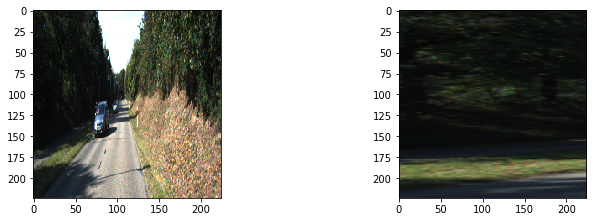

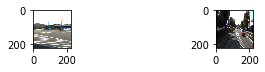

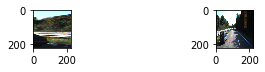

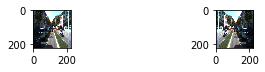

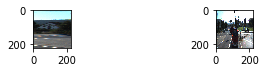

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"]) 
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"]) 
  
    plt.show()

### * Data Set 구성

- tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):

    def __init__(self, dir_path, batch_size=4,img_size=(224, 224, 3),
               output_size=(224, 224),is_train=True,augmentation=None):

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[index*self.batch_size:(index + 1)*self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {"image": _input,"mask": _output,}
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(dir_path, augmentation=augmentation,)

test_generator = KittiGenerator(dir_path, augmentation=test_preproc,is_train=False)

## 2. 시맨틱 세그멘테이션 [ 모델을 만들고 학습 ]
### Step 2. U-Net++ 모델의 구현

- U-Net의 모델 구조와 소스코드를 면밀히 비교 -> U-Net++를 어떻게 구현가능
- U-Net 자체에 대한 이해도도 증진
- U-Net의 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능

### * Model 만들기

## < U-Net model >

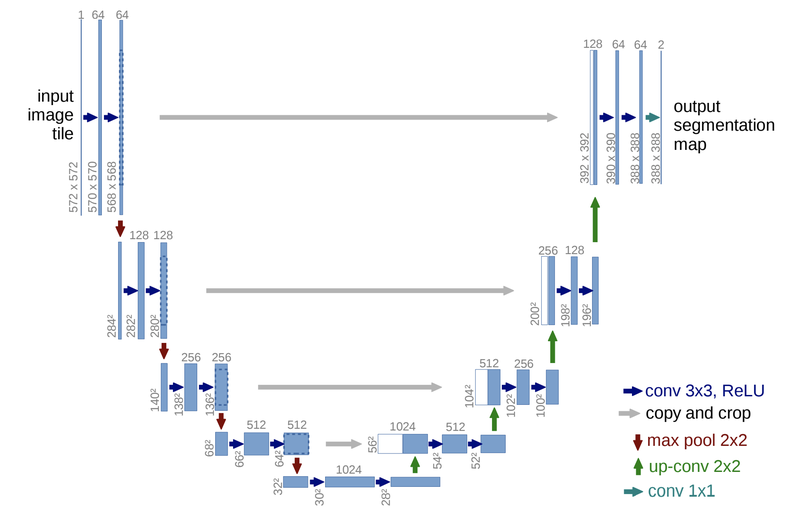

In [6]:
def build_Unet_model(input_shape=(224, 224, 3)): 
    
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model


## < U-Net++ model >

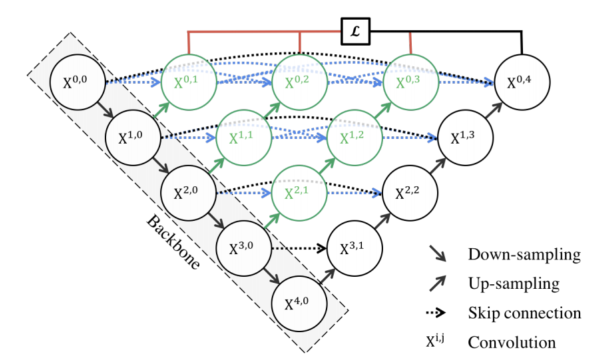

In [7]:
def build_UnetPP_model(input_shape=(224, 224, 3)): 
    
    inputs = Input(input_shape)

    #Contracting Path
    conv10 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv10 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv10)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv10)
    
    conv20 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv20 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv20)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv20)
    
    conv30 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv30 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv30)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv30)
    
    conv40 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv40 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv40)
    drop4 = Dropout(0.5)(conv40)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv50 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv50 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv50)

    #Expanding Path
    drop5 = Dropout(0.5)(conv50)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge41 = concatenate([drop4,up6], axis = 3)
    
    up40 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop4)) 
    merge31  = concatenate([conv30,up40], axis = 3)
    conv41 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge41)
    conv41 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv41)
    up41 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv41))       
    merge32  = concatenate([conv30,merge31,up41], axis = 3)
    
    up30 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv30))
    merge21 = concatenate([conv20,up30], axis = 3)
    conv31 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge31)
    conv31 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv31)
    up31 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv31))
    merge22 = concatenate([conv20,merge21,up31], axis = 3)
    conv32 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge32)
    conv32 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv32)
    up32 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv32))
    merge23 = concatenate([conv20,merge21,merge22,up32], axis = 3)
    
    
    up20 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv20))
    merge11 = concatenate([conv10,up20], axis = 3)
    conv21 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge21)
    conv21 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv21)
    up21 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv21))
    merge12 = concatenate([conv10,merge11,up21], axis = 3)
    conv22 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge22)
    conv22 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv22)
    up22 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv22))
    merge13 = concatenate([conv10,merge11,merge12,up22], axis = 3)
    conv23 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge23)
    conv23 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv23)
    up23 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(merge23))    
    merge14 = concatenate([conv10,merge11,merge12,merge13,up23], axis = 3)
    
    conv14 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge14)
    conv15 = Conv2D(1, 1, activation='relu', padding='same',kernel_initializer='he_normal')(merge14)

    model = Model(inputs = inputs, outputs = conv15)
    return model


### * Model 학습

In [8]:
'''U-Net model 학습'''
model = build_Unet_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(generator=train_generator, validation_data=test_generator,
     steps_per_epoch=len(train_generator),epochs=5)

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path) 

/home/myungjin-kim/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
43/43 [==============================] - 191s 4s/step - loss: 0.5483 - val_loss: 0.0918
Epoch 2/5
43/43 [==============================] - 188s 4s/step - loss: 0.1200 - val_loss: 0.1104
Epoch 3/5
43/43 [==============================] - 190s 4s/step - loss: 0.1008 - val_loss: 0.0793
Epoch 4/5
43/43 [==============================] - 190s 4s/step - loss: 0.0755 - val_loss: 0.0660
Epoch 5/5
43/43 [==============================] - 191s 4s/step - loss: 0.0677 - val_loss: 0.0872


In [9]:
'''U-Net++ model 학습'''
model_pp = build_UnetPP_model()
model_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [10]:
model_pp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_pp.fit_generator(generator=train_generator, validation_data=test_generator,
     steps_per_epoch=len(train_generator),epochs=5)

model_pp_path = dir_path + '/seg_model_unet.h5'
model_pp.save(model_pp_path)  

Epoch 1/5
43/43 [==============================] - 417s 10s/step - loss: 0.9372 - val_loss: 0.8777
Epoch 2/5
43/43 [==============================] - 414s 10s/step - loss: 0.7317 - val_loss: 0.6792
Epoch 3/5


KeyboardInterrupt: 

## 3. 시맨틱 세그멘테이션 [ 모델의 결과를 시각화 ]
### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

- 두 모델의 정량적, 정성적 성능을 비교
- 시각화, IoU 계산 등을 체계적으로 시도

### < U-Net의 세그멘테이션 결과 >

In [11]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold: 도로인식 결과범위
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

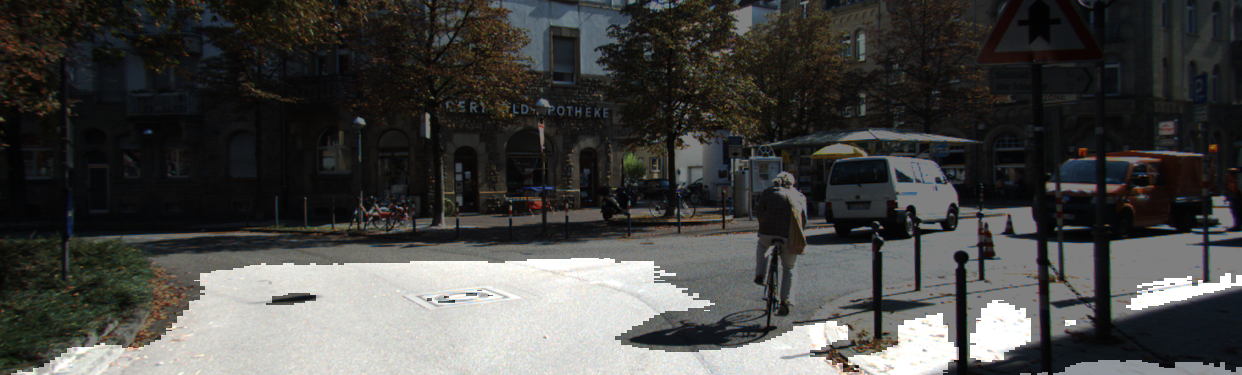

In [12]:
'''U-Net'''
i = 3     
get_output(model,test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png')

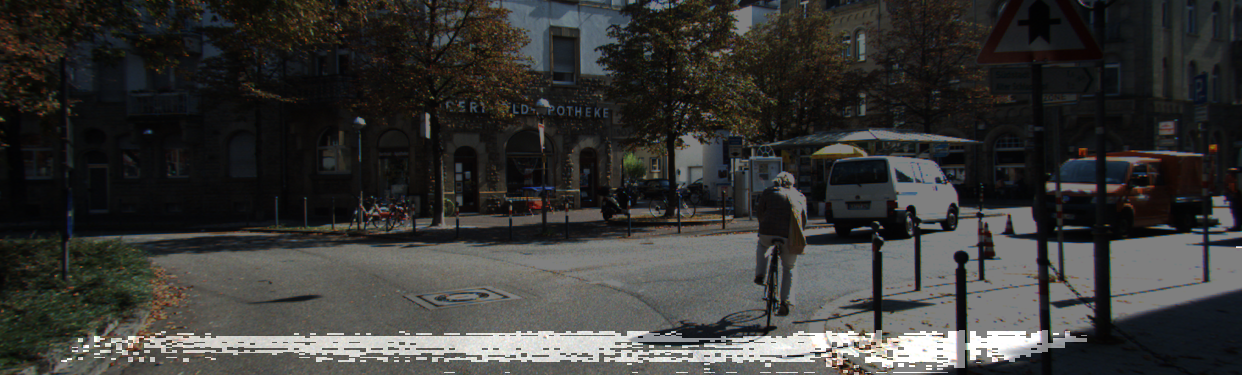

In [13]:
'''U-Net++'''
i = 3    
get_output(model_pp,test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png')

In [14]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [15]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [16]:
'''U-Net'''

i = 3    
output, prediction, target = get_output(model,test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png')

calculate_iou_score(target, prediction)

IoU : 0.523531


0.5235308265854245

In [17]:
'''U-Net++'''

i = 3   
output, prediction, target = get_output(model_pp,test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png')

calculate_iou_score(target, prediction)

IoU : 0.126325


0.12632478632478633